In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pySIVAK import pySIVAK

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

In [4]:
inputdir = Path(r'../../data_results')
outputdir = Path('Ontwerp laagwaterbeleid')

# Set scenario's

In [5]:
# Set constants
water_plane = {
    'Born': {
        'Born Oude Sluis': 136 * 16,
        'Born Kolk I': 242*16,  # Middenkolk?
        'Born Kolk II': 154*16, # Oostkolk?
        },
    'Maasbracht': {
        'Westkolk': 157 * 16,
        'Middenkolk': 157 * 16,
        'Oostkolk': 245 * 16
    },
    'Heel': {
        'Heel Kolk X': 154*15.5,  # Which?
        'Oostkolk': 246 * 13.5  # Missing?
    }
}

dH = {
    'Born': 11.35,
    'Maasbracht': 11.85,
    'Heel': 6.7
}

In [6]:
# Compute scenario's for using pumps

max_pomp_inzet = {
    'Born': 9,
    'Maasbracht': 12,
    'Heel': 0,
}

seconde_per_week = 7*24*60*60
pompkosten_per_seconde = 0.0048 # euro per m3

In [34]:
# Set scenario's
lock = 'Maasbracht'
SIVAK_scenarios = {
                'SLMSBR KBN 0 - Base, Area': 'REF',
                'SLMSBR KBN 4 - R 40 80 30': 'R 40 80 30',
                'SLMSBR KBN 5 - R 40 80 60': 'R 40 80 60',
                'SLMSBR KBN 6 - R 40 80 90': 'R 40 80 90',
                'SLMSBR KBN 7 - R 60 80 90': 'R 60 80 90',
                'SLMSBR KBN 8 - R 80 80 90': 'R 80 80 90',
                'SLMSBR KBN 9 - R 80 80 110': 'R 80 80 110'
            }

# Compute max waiting time, based on scenario-name
maximum_waiting_time = {s: float(s.split(' ')[-1]) / 60 for s in SIVAK_scenarios.values() if s != 'REF'}
maximum_waiting_time['REF'] = 9999

scenarios_ref = 'REF'
scenarios_zuinig = ['R 40 80 30', 'R 40 80 60']  # Het beste zuinig scenario, gebruikt in laagwater strategie
scenarios_schutregimes = ['R 40 80 30', 'R 40 80 60', 'R 40 80 90', 'R 60 80 90', 'R 80 80 110']  # Alle schutregimes die toepasbaar zijn in laagwaterstrategie
scenarios_deleted =  ['R 80 80 90']   # Alle scenario's die niet gebruikt worden

In [8]:
# # Set scenario's
# lock = 'Born'
# SIVAK_scenarios = {
#                 'SLB 0 - Base': 'REF',
#                 'SLB 1 - R 40 80 15': 'R 40 80 15',
#                 'SLB 2 - R 40 80 20': 'R 40 80 20',
#                 'SLB 3 - R 40 80 30': 'R 40 80 30',
#                 'SLB 4 - R 40 80 45': 'R 40 80 45',
#                 'SLB 5 - R 20 60 30': 'R 20 60 30',
#                 'SLB 6 - R 20 60 45': 'R 20 60 45'
#             }

# # Compute max waiting time, based on scenario-name
# maximum_waiting_time = {s: float(s.split(' ')[-1]) / 60 for s in SIVAK_scenarios.values() if s != 'REF'}
# maximum_waiting_time['REF'] = 9999

# scenarios_ref = 'REF'
# scenarios_zuinig = 'R 20 60 45'
# scenarios_schutregimes = ['R 40 80 15', 'R 20 60 45', 'R 40 80 45']
# scenarios_deleted = ['R 40 80 20', 'R 40 80 30', 'R 20 60 30']

In [9]:
# # Set scenario's
# lock = 'Heel'
# SIVAK_scenarios = {
#                 'SLH KBN 0 - Base': 'REF',
#                 'SLH KBN 1 - R 40 80 15': 'R 40 80 15',
#                 'SLH KBN 2 - R 40 80 20': 'R 40 80 20',
#                 'SLH KBN 3 - R 40 80 30': 'R 40 80 30',
#                 'SLH KBN 4 - R 40 80 45': 'R 40 80 45',
#                 'SLH KBN 5 - R 20 60 30': 'R 20 60 30',
#                 'SLH KBN 6 - R 20 60 45': 'R 20 60 45'
#             }

# # Compute max waiting time, based on scenario-name
# maximum_waiting_time = {s: float(s.split(' ')[-1]) / 60 for s in SIVAK_scenarios.values() if s != 'REF'}
# maximum_waiting_time['REF'] = 9999


# scenarios_ref = 'REF'
# scenarios_zuinig = 'R 20 60 45'
# scenarios_deleted =  []
# scenarios_schutregimes = ['R 40 80 15', 'R 40 80 20', 'R 40 80 30', 'R 40 80 45', 'R 20 60 30', 'R 20 60 45']

# Read results

In [10]:
# Read instances for all runs in dict
S = {}

for scenario, name in SIVAK_scenarios.items():
    summary_file =       inputdir / lock / 'KPI LockChambers Summary' / f'KPI_LockChambers_Summary_Avg ({scenario}).xlsx'
    ships_file =         inputdir / lock / 'Log Generated Ships' / f'Log Generated Ships ({scenario}).xlsx'
    levelings_file =     inputdir / lock / 'Log Locks Leveling' / f'Log Locks Leveling ({scenario}).xlsx'
    transit_times_file = inputdir / lock / 'Log Locks Transit Times' / f'Log Locks Transit Times ({scenario}).xlsx'

    s = pySIVAK(ships_file, levelings_file, transit_times_file, summary_file)
    
    s.correction_waitingtimes_without_new_arrivals(maximum_waiting_time=maximum_waiting_time[name])
    s.correction_leveling_without_utilization()
    s.correction_waterloss(water_plane=water_plane[lock], dH=dH[lock], downward_leveling_side=1, correct_ship_volume=True)
    
    s.name = name
    
    S[name] = s


In [81]:
# Read and translate costs per shiptype
costs_per_ship_per_hour = pd.read_excel('Costs_per_shiptype.xlsx', index_col=0, header=[0,1])['Costs_per_h'].mean(axis=1)

costs_per_ship_per_hour['overig'] = 80
costs_per_ship_per_hour['recreatievaart'] = 0

vertaaltabel_SIVAK_BIVAS = pd.read_excel('Vertaaltabel_SIVAK_BIVAS.xlsx',index_col=0)

cost_per_sivakship_per_hour = vertaaltabel_SIVAK_BIVAS.reset_index().merge(costs_per_ship_per_hour.reset_index(), left_on='BIVAS-ship', right_on='ShipTypeID').set_index('SIVAK-ship')[0]
cost_per_sivakship_per_minute = cost_per_sivakship_per_hour / 60


def compute_costs_per_hour(self):
    T = self.passage_time_per_hour_per_day_per_ship_sum()
    costs_per_ship_per_hour = T.multiply(cost_per_sivakship_per_minute, axis=1)
    costs_per_hour = costs_per_ship_per_hour.sum(axis=1).unstack().fillna(0)
    return costs_per_hour

In [116]:
# Compute some numbers per scenario: average discharge (m3/s), average passage time (minutes), costs for ships per week (eur)
Q_avg = {name: s.waterloss_per_hour_per_day().mean().mean() for name, s in S.items()}
T_avg = {name: s.transit_times['Passage time (hours)'].mean() * 60 for name, s in S.items()}
K_sum = {name: compute_costs_per_hour(s).sum().sum() for name, s in S.items()}

scenarios = pd.DataFrame({'Passage time average (min)': T_avg, 'Discharge average (m3/s)': Q_avg, 'Shipping costs (eur)': K_sum})

In [117]:
scenarios['Pompinzet (m3/s)'] = 0
scenarios['Toename kosten scheepvaart (eur) door hevelend'] = 0
scenarios['Waterbesparing door hevelend (m3/s)'] = 0

In [118]:
# Some derived stats
scenarios['Besparing debiet scheepvaart (m3/s)'] = scenarios.loc['REF', 'Discharge average (m3/s)'] - scenarios['Discharge average (m3/s)'] 
scenarios['Toename kosten scheepvaart (eur)'] = scenarios['Shipping costs (eur)'] - scenarios['Shipping costs (eur)'][0]

### Create scenario's with pumps

In [119]:
def create_pomp_scenario(s, Q_pump):
    name = f'{s} P {Q_pump:.1f}'
    scenario = scenarios.loc[s].copy()
    scenario.name = name
    scenario['Pompinzet (m3/s)'] = Q_pump
    return  scenario

In [120]:
# Scenario of max pumping in ref

new_scenario = create_pomp_scenario('REF', Q_pump=max_pomp_inzet[lock])
scenarios = scenarios.append(new_scenario)

scenarios_maxpompen = new_scenario.name

In [121]:
# # Create scenario's with equal pumps as ships, starting at REF
# starting_scen = scenarios_ref
# besparing = - (scenarios.loc[scenarios_schutregimes, 'Discharge average (m3/s)'] - scenarios.loc[starting_scen, 'Discharge average (m3/s)'])

# laagwaterbeleid_schutregimes_equalpumps_tov_ref = [scenarios_ref]
# for s, Q in besparing.items():
#     new_scenario = create_pomp_scenario(s, Q_pump=Q)
#     scenarios = scenarios.append(new_scenario)

#     laagwaterbeleid_schutregimes_equalpumps_tov_ref.append(new_scenario.name)

In [122]:
# Create scenario's with equal pumps as ships, starting at R 40 80 30
starting_scen = scenarios_zuinig[0]
besparing = - (scenarios.loc[scenarios_schutregimes, 'Discharge average (m3/s)'] - scenarios.loc[starting_scen, 'Discharge average (m3/s)'])

laagwaterbeleid_schutregimes_equalpumps = [scenarios_ref, starting_scen]
for s, Q in besparing.items():
    new_scenario = create_pomp_scenario(s, Q_pump=Q)
    scenarios = scenarios.append(new_scenario)
    
    laagwaterbeleid_schutregimes_equalpumps.append(new_scenario.name)
    
Q_extra = max_pomp_inzet[lock]
new_scenario = create_pomp_scenario(s, Q_pump=Q_extra)
scenarios = scenarios.append(new_scenario)

laagwaterbeleid_schutregimes_equalpumps.append(new_scenario.name)

In [123]:
# Create scenario's with equal costs for pumps as ships
besparing = scenarios.loc[scenarios_schutregimes, 'Toename kosten scheepvaart (eur)'] / (seconde_per_week * pompkosten_per_seconde)

laagwaterbeleid_schutregimes_equalcostspumps = [scenarios_ref]
for s, Q in besparing.items():
    new_scenario = create_pomp_scenario(s, Q_pump=Q)
    scenarios = scenarios.append(new_scenario)
    
    laagwaterbeleid_schutregimes_equalcostspumps.append(new_scenario.name)

In [124]:
# Max pompen bij zuinig 
new_scenario = create_pomp_scenario(scenarios_zuinig[-1], Q_pump=max_pomp_inzet[lock])
scenarios = scenarios.append(new_scenario)

laagwaterbeleid_zuinig_maxpompen = [scenarios_ref] + scenarios_zuinig + [new_scenario.name]

### Hevelend schutten

In [143]:
# if lock == 'Maasbracht':

# Deze functies nog bepalen
toename_nivelleertijd_functie = lambda besparing_hevelend: besparing_hevelend * 20 # min
toename_gem_wachttijd_functie = lambda schuttingen_hevelend: schuttingen_hevelend * 5 # min

def create_scenario_hevelend(ref, schuttingen_hevelend, besparing_hevelend):

    toename_nivelleertijd = toename_nivelleertijd_functie(besparing_hevelend) # min
    toename_gem_wachttijd = toename_gem_wachttijd_functie(schuttingen_hevelend) # min
    

    # Aantal op-en-neer schuttingen --> waterbesparing per seconde
    n_schuttingen = S[ref].levelings.groupby(['Lock Chamber']).count()['Leveling ID'] / S[ref].replications / 2
    volume_zonder_hevelend = n_schuttingen * dH[lock] * pd.Series(water_plane[lock])
    volume_besparing_hevelend = volume_zonder_hevelend * besparing_hevelend * schuttingen_hevelend
    debiet_besparing_hevelend = (volume_besparing_hevelend / seconde_per_week).sum()

    # Aantal schepen --> Toename passeerkosten
    n_ships_per_types = S[ref].transit_times.groupby('Class')['Lock'].count() / S[ref].replications

    minutes_per_shiptype = n_ships_per_types * (toename_nivelleertijd + toename_gem_wachttijd) * schuttingen_hevelend

    shipping_costs_per_ship = minutes_per_shiptype.multiply(cost_per_sivakship_per_minute).dropna()
    shipping_costs_total = shipping_costs_per_ship.sum()

    name = f'{ref} H {(schuttingen_hevelend * 100):.0f} {(besparing_hevelend * 100):.0f}'
    scenario = scenarios.loc[ref].copy()
    scenario.name = name
    scenario['Toename kosten scheepvaart (eur) door hevelend'] = shipping_costs_total
    scenario['Waterbesparing door hevelend (m3/s)'] = debiet_besparing_hevelend
    
    return  scenario
    

new_scenario = create_scenario_hevelend(ref = 'REF', schuttingen_hevelend = 1, besparing_hevelend = 0.50)
scenarios = scenarios.append(new_scenario)

### Stats

In [144]:
# Some more derived statistics
scenarios['Totale toename kosten scheepvaart (eur)'] = scenarios['Toename kosten scheepvaart (eur)'] + scenarios['Toename kosten scheepvaart (eur) door hevelend']
scenarios['Totale toename kosten scheepvaart (eur) per dag'] = scenarios['Totale toename kosten scheepvaart (eur)'] / 7

scenarios['Pompkosten (eur)'] = scenarios['Pompinzet (m3/s)'] * seconde_per_week * pompkosten_per_seconde
scenarios['Pompkosten (eur) per dag'] = scenarios['Pompkosten (eur)'] / 7

scenarios['Totale debiet (m3/s)'] = scenarios['Discharge average (m3/s)'] - scenarios['Pompinzet (m3/s)'] - scenarios['Waterbesparing door hevelend (m3/s)']
scenarios['Totale waterbesparing (m3/s)'] = scenarios['Totale debiet (m3/s)'][0] - scenarios['Totale debiet (m3/s)']

scenarios['Totale kosten (eur)'] = scenarios['Totale toename kosten scheepvaart (eur)'] + scenarios['Pompkosten (eur)']
scenarios['Totale kosten (eur) per dag'] = scenarios['Totale kosten (eur)'] / 7
scenarios['Totale kosten (eur) per uur'] = scenarios['Totale kosten (eur)'] / 7 / 24

### Plots

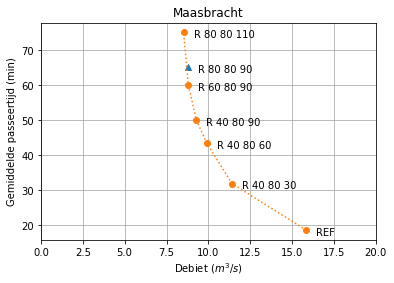

In [145]:
# Debiet -- Passeertijd
f, ax = plt.subplots()

plot_scenarios = scenarios_deleted
scenarios.loc[plot_scenarios].plot(x='Discharge average (m3/s)', y='Passage time average (min)', zorder=3, marker='^', ls='none', legend=False, ax=ax)

plot_scenarios = [scenarios_ref] + scenarios_schutregimes
scenarios.loc[plot_scenarios].plot(x='Discharge average (m3/s)', y='Passage time average (min)', zorder=3, marker='o', ls=':', legend=False, ax=ax)

for i, r in scenarios.loc[plot_scenarios + scenarios_deleted].iterrows():
    plt.annotate(i, xy=(r['Discharge average (m3/s)'], r['Passage time average (min)']), xytext=(10, -5), textcoords='offset points')

plt.xlim(0, 20)
# plt.ylim(0, 90)
plt.xlabel('Debiet ($m^3/s$)')
plt.ylabel('Gemiddelde passeertijd (min)')
plt.grid(c='#AAA')
plt.title(lock)

plt.savefig(    outputdir / f'{lock}_Debiet_passeertijd.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Debiet_passeertijd.svg', bbox_inches='tight')


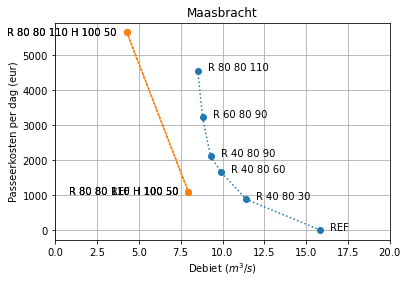

In [146]:
# Debiet -- Passeerkosten
f, ax  = plt.subplots()

plot_scenarios = [scenarios_ref] + scenarios_schutregimes
scenarios.loc[plot_scenarios].plot(x='Discharge average (m3/s)', y='Totale kosten (eur) per dag', ls=':', marker='o', legend=False, ax=ax)

for i, r in scenarios.loc[plot_scenarios].iterrows():
    plt.annotate(i, xy=(r['Discharge average (m3/s)'], r['Totale kosten (eur) per dag']), xytext=(10, 0), textcoords='offset points')


plot_scenarios_hevelend = [s for s in scenarios.index if 'H' in s]
scenarios.loc[plot_scenarios_hevelend].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls=':', marker='o', legend=False, ax=ax)

for i, r in scenarios.loc[plot_scenarios_hevelend].iterrows():
    plt.annotate(i, xy=(r['Totale debiet (m3/s)'], r['Totale kosten (eur) per dag']), xytext=(-10, 0), textcoords='offset points', ha='right', va='center')



plt.xlim(0, 20)
# plt.ylim(0, 7000)
plt.xlabel('Debiet ($m^3/s$)')
plt.ylabel('Passeerkosten per dag (eur)')
plt.grid(c='#AAA')
plt.title(lock)

# plt.yticks(locs, map(lambda x: "%.1f" % x, plt.gca().get_yticks()/1e3))
plt.savefig(    outputdir / f'{lock}_Debiet_passeerkosten.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Debiet_passeerkosten.svg', bbox_inches='tight')
# plotdata.to_csv(outputdir / f'{lock}_Debiet_passeertijd.csv')

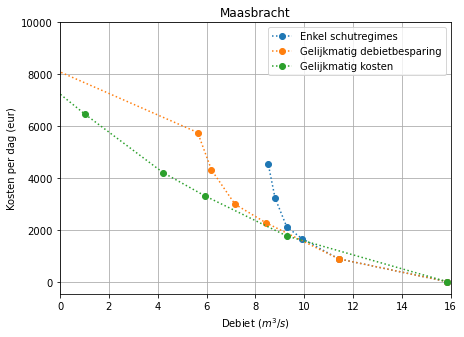

In [152]:
# plotdata.plot.scatter(x='Discharge average (m3/s)', y='Shipping costs (eur)', zorder=3)
# plotdata.iloc[:-1].set_index('Totale debiet (m3/s)')['Totale kosten (eur)'].plot(ls=':', marker='o')
# plotdata.iloc[[0, -1], :].set_index('Totale debiet (m3/s)')['Totale kosten (eur)'].plot(ls=':', marker='o')
f, ax = plt.subplots(figsize=(7,5))

scenarios.loc[[scenarios_ref] + scenarios_schutregimes].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls=':', marker='o', ax=ax, label='Enkel schutregimes')
# scenarios.loc[[scenarios_ref] + [scenarios_maxpompen]].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls=':', marker='o', ax=ax, label='Enkel pompen')
scenarios.loc[laagwaterbeleid_schutregimes_equalpumps].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls=':', marker='o', ax=ax, label='Gelijkmatig debietbesparing')
scenarios.loc[laagwaterbeleid_schutregimes_equalcostspumps].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls=':', marker='o', ax=ax, label='Gelijkmatig kosten')
# scenarios.loc[laagwaterbeleid_zuinig_maxpompen].plot(x='Totale debiet (m3/s)', y='Totale kosten (eur) per dag', ls=':', marker='o', ax=ax, label='Zuinig dan pompen')

scenarios_zuinig_maxpompen
# for i, r in plotdata.iterrows():
#     plt.annotate(i, xy=(r['Totale debiet (m3/s)'], r['Totale kosten (eur)']), xytext=(10, 0), textcoords='offset points')

    
    
plt.xlim(0, 16)
# plt.ylim(0, 10e3)
plt.xlabel('Debiet ($m^3/s$)')
plt.ylabel('Kosten per dag (eur)')
plt.grid(c='#AAA')
plt.title(lock)

# plt.yticks(locs, map(lambda x: "%.1f" % x, plt.gca().get_yticks()/1e6))
plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_scenarios.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_scenarios.svg', bbox_inches='tight')
# plotdata.to_csv(outputdir / f'{lock}_Debiet_passeertijd.csv')

In [148]:
scenarios.to_csv(outputdir / f'{lock}_Laagwaterbeleid_scenarios.csv')

In [149]:
# scenarios_laagwaterbeleid = [scenarios_ref] + scenarios_zuinig_maxpompen
laagwaterbeleid_toepassing = [scenarios_ref] + scenarios_schutregimes_equalcostspumps

laagwaterbeleid = scenarios.loc[laagwaterbeleid_toepassing]

laagwaterbeleid = laagwaterbeleid.set_index('Totale debiet (m3/s)')

laagwaterbeleid.to_csv(outputdir / f'{lock}_Laagwaterbeleid.csv')

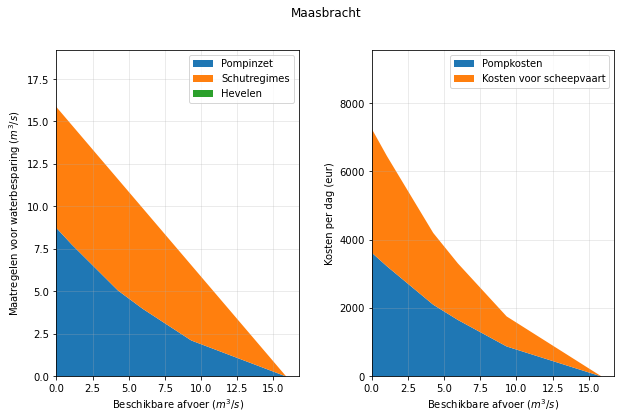

In [151]:
f, ax = plt.subplots(ncols=2, figsize=(10,6))
plt.subplots_adjust(wspace=0.3)

plt.sca(ax[0])
laagwaterbeleid.plot(kind='area', y=['Pompinzet (m3/s)', 'Besparing debiet scheepvaart (m3/s)', 'Waterbesparing door hevelend (m3/s)'], ax=ax[0], label=['Pompinzet', 'Schutregimes', 'Hevelen'], lw=0)

plt.xlim(0, )
plt.ylim(0)
plt.grid(alpha=0.3)
plt.xlabel('Beschikbare afvoer ($m^3/s$)')
plt.ylabel('Maatregelen voor waterbesparing ($m^3/s$)')
# plt.legend()

laagwaterbeleid.plot(kind='area', y=['Pompkosten (eur) per dag', 'Totale toename kosten scheepvaart (eur) per dag'], ax=ax[1], label=['Pompkosten', 'Kosten voor scheepvaart'], lw=0)

plt.sca(ax[1])
plt.xlim(0, )
plt.ylim(0)
plt.grid(alpha=0.3)
plt.xlabel('Beschikbare afvoer ($m^3/s$)')
plt.ylabel('Kosten per dag (eur)')

plt.suptitle(lock)

plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid.svg', bbox_inches='tight')